In [ ]:
import os
import re
import json
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import string
from collections import Counter
from wordcloud import WordCloud

import spacy
from spacy import displacy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abhinavdholi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavdholi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abhinavdholi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Data

In [ ]:
# directory containing raw MACCROBAT2018 clinical annotation data
data_dir = "../data/raw/MACCROBAT2018"

In [ ]:
def get_doc_ids(data_dir):
    """
    Extracts unique document IDs from a directory of files.
    """
    if not os.path.exists(data_dir):
        raise OSError(f"Directory {data_dir} does not exist.")
    
    doc_ids = []
    for doc in os.listdir(data_dir):
        doc_id = doc.split(".")[0]
        if doc_id not in doc_ids:
            doc_ids.append(doc_id)

    if not doc_ids:
        raise ValueError(f"No files with expected naming convention found in {data_dir}.")
    
    return doc_ids


In [7]:
doc_ids = get_doc_ids(data_dir)
print(f"Number of documents is {len(doc_ids)}")

Number of documents is 200


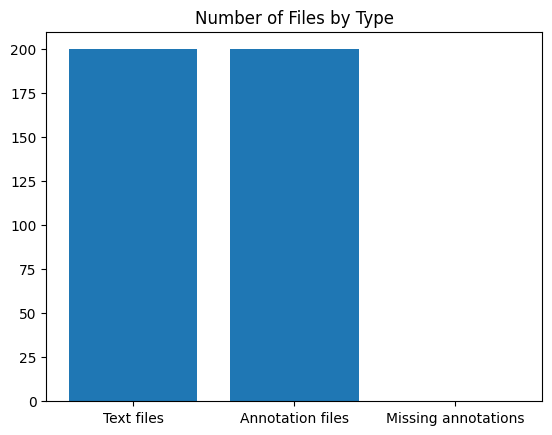

In [ ]:
text_files = [f for f in os.listdir(data_dir) if f.endswith('.txt')]
ann_files = [f for f in os.listdir(data_dir) if f.endswith('.ann')]

text_ids = [f.split('.')[0] for f in text_files]
ann_ids = [f.split('.')[0] for f in ann_files]

# counts number of files without annotations
missing_anns = 0
for text_id in text_ids:
    if text_id not in ann_ids:
        missing_anns += 1

# creates bar chart
labels = ['Text files', 'Annotation files', 'Missing annotations']
counts = [len(text_files), len(ann_files), missing_anns]

plt.bar(labels, counts)
plt.title('Number of Files by Type')
plt.show()


## Step 2: Load the .txt files

In [ ]:
import os

def load_txt_data(txt_dir, doc_ids):
    """
    Loads text data from a directory of .txt files into a dictionary.
    """
    if not os.path.exists(txt_dir):
        raise OSError(f"Directory {txt_dir} does not exist.")

    data = {}
    
    for file_id in doc_ids:
        
        file_name = file_id + ".txt"
        
        with open(os.path.join(txt_dir, file_name), "r") as f:
            text = f.read()
            
        data[file_id] = {
                "text": text, 
                "annotations": []
        }

    if not data:
        raise ValueError(f"No .txt files found in {txt_dir}.")

    return data

In [10]:
data = load_txt_data(data_dir, doc_ids)
print("data: {")
for doc_id in list(data.keys())[:3]:
    print(f"\t'{doc_id}': {{")
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"\t\ttext:\t{text[:78]} .....")
    print(f"\t\tannotations: {annotations}")
    print("\t},")
print('\t....')
print("}")

data: {
	'19860925': {
		text:	Our 24-year-old non-smoking male patient presented with repeated hemoptysis in .....
		annotations: []
	},
	'26361640': {
		text:	A 68-year-old female nonsmoker, nondrinker with a medical history of hypertens .....
		annotations: []
	},
	'26228535': {
		text:	A 25-year-old female patient had noticed left-sided visual loss and amenorrhea .....
		annotations: []
	},
	....
}


#### Document Length Distribution

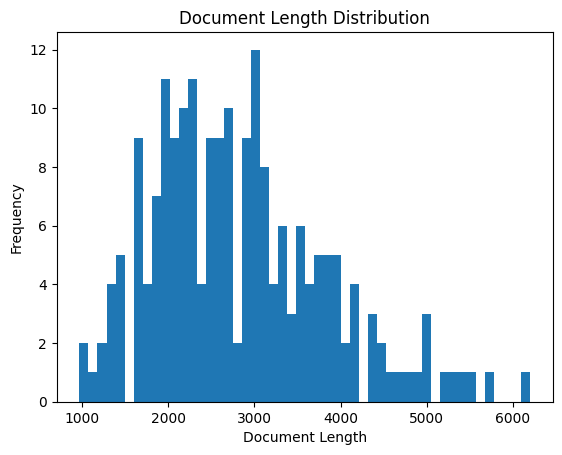

In [ ]:
def get_doc_length_distribution(data):
    """
    Computes the document length distribution for a dictionary of documents.
    """
    
    doc_lengths = []
    for doc_id in data:
        
            text = data[doc_id]['text']
            
            doc_length = len(text)
            doc_lengths.append(doc_length)
    
    return doc_lengths


doc_lengths = get_doc_length_distribution(data)

# plots the document length distribution
plt.hist(doc_lengths, bins=50)
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.title("Document Length Distribution")
plt.show()

#### Sentence Count Distribution

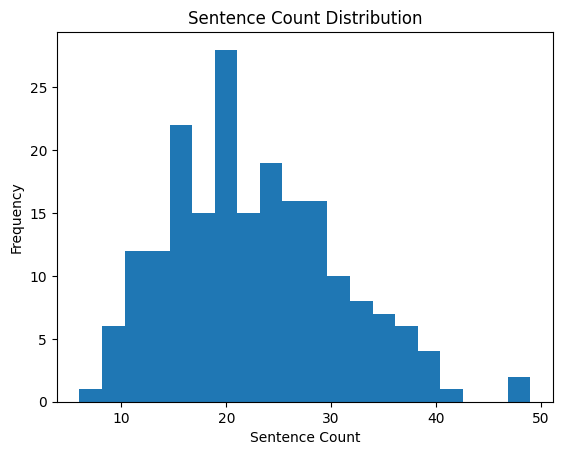

In [ ]:
def get_doc_sentence_counts(data):
    """
    Computes the number of sentences in each document.
    """
    
    sentence_counts = []
    for doc_id in data:
        text = data[doc_id]['text']
        sentences = nltk.sent_tokenize(text)
        sentence_count = len(sentences)
        sentence_counts.append(sentence_count)
    
    return sentence_counts

# gets the sentence counts
sentence_counts = get_doc_sentence_counts(data)

# plots the sentence count distribution
plt.hist(sentence_counts, bins=20)
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.title("Sentence Count Distribution")
plt.show()


#### Word Frequency Distribution

In [ ]:
def get_word_frequency_distribution(data):
    """
    Computes the word frequency distribution for a dictionary of documents.
    """
    
    # loads stop words
    stop_words = set(stopwords.words('english'))
    
    # tokenizes text and count word frequency
    all_words = []
    for doc_id in data:
        text = data[doc_id]['text']
        words = nltk.word_tokenize(text)
        words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
        all_words.extend(words)
        
    word_freq = dict(Counter(all_words))
    
    return word_freq

def plot_word_freq_distribution(word_freq):
    """
    Plots the word frequency distribution.
    """

    # sorts the word frequencies in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # extracts the word and frequency lists from the sorted word frequency tuples
    words, freqs = zip(*sorted_word_freq)

    # plots the word frequency distribution
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), freqs)

    plt.ylabel('Frequency')
    plt.title('Word Frequency Distribution')
    plt.show()



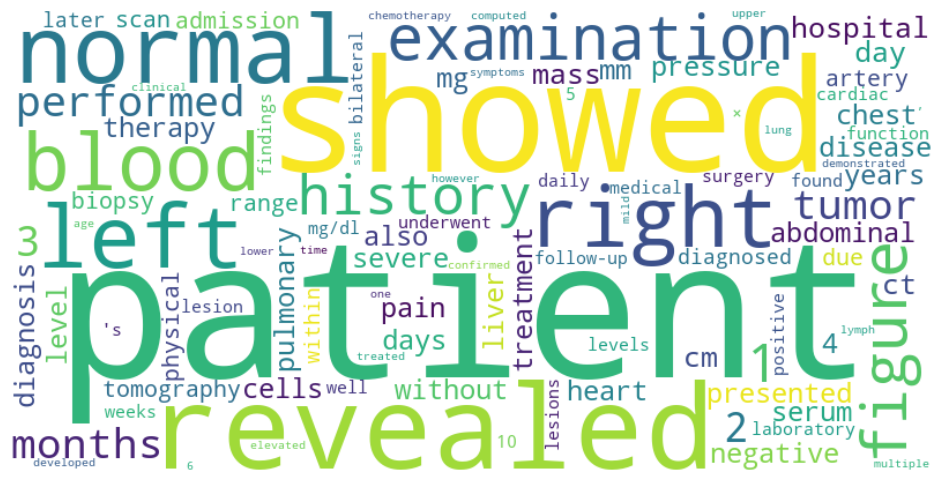

In [ ]:

def get_word_frequencies(data):
    """
    Computes the word frequency distribution for a dictionary of documents.
    """
    
    word_freq = FreqDist()
    stop_words = set(stopwords.words('english'))
    for doc_id in data:
        text = data[doc_id]['text']
        tokens = word_tokenize(text)
        
        # removes stopwords and punctuation
        clean_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in string.punctuation]
        
        # updates word frequency distribution
        word_freq.update(clean_tokens)
    
    return word_freq

def plot_wordcloud(word_freq):
    """
    Plots a wordcloud of the word frequency distribution.
    """
    
    wc = WordCloud(background_color='white', max_words=100, width=800, height=400)
    wc.generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
word_freq = get_word_frequencies(data)
plot_wordcloud(word_freq)

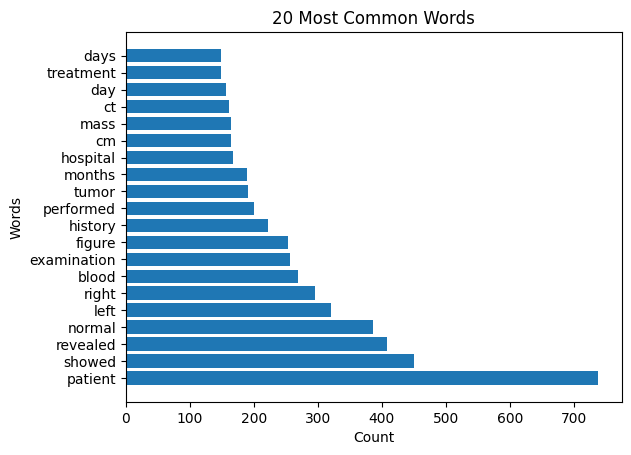

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import collections


stop_words = set(stopwords.words('english'))

all_words = []
for doc_id in data:
    text = data[doc_id]['text']
    words = nltk.word_tokenize(text)
    words = [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]
    all_words.extend(words)
    
# gets the word frequency distribution
word_freq = Counter(all_words)
# removes stop words
for stop_word in stop_words:
    del word_freq[stop_word]

# gets the 20 most common words
most_common = word_freq.most_common(20)

# creates a horizontal bar chart
words = [word[0] for word in most_common]
counts = [word[1] for word in most_common]
plt.barh(words, counts)

# adds labels and title
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("20 Most Common Words")

plt.show()

#### Non-ASCII Characters

In [ ]:
non_ascii_characters = []
# loops through each file in the folder
for doc_id in doc_ids:
    # checks if the file is a .txt file
    filename = f"{doc_id}.txt"
    # opens the file
    with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
        # reads the file content
        file_content = file.read()
        # finds all non-ASCII characters using regular expressions
        non_ascii_chars = re.findall(r'[^\x00-\x7F]', file_content)
        # prints the filename and the special characters found
        if non_ascii_chars: 
            print(f'File: {filename}, Non-ASCII characters: {non_ascii_chars}')        
        non_ascii_characters.extend(non_ascii_chars)

File: 19860925.txt, Non-ASCII characters: ['×', '\u200b', '\u200b']
File: 26361640.txt, Non-ASCII characters: ['μ', 'μ', '\u200b', '’']
File: 26228535.txt, Non-ASCII characters: ['μ', '–', '’']
File: 23678274.txt, Non-ASCII characters: ['µ', 'µ', 'µ', 'µ']
File: 25853982.txt, Non-ASCII characters: ['×']
File: 28103924.txt, Non-ASCII characters: ['–', '–', '–', '’', '’', '’', '–', '’']
File: 27064109.txt, Non-ASCII characters: ['×', '–', '–', '–', 'μ', '–', '–', '’', '’', 'β', 'λ', '’', 'β']
File: 20146086.txt, Non-ASCII characters: ['–', '–']
File: 28353558.txt, Non-ASCII characters: ['γ', '\u200a']
File: 22515939.txt, Non-ASCII characters: ['\u200b']
File: 28353588.txt, Non-ASCII characters: ['×', '×', '\u200a', '\u200a', '\u200a', '×', '\u200a', '\u200a', '×', '\u200a', '\u200a', '–', '\u200a', '\u200a', '–']
File: 26309459.txt, Non-ASCII characters: ['µ', 'µ']
File: 28272235.txt, Non-ASCII characters: ['’', '\u200a', '\u200a', '×', '\u200a', '–', '\u200a', '×', '\u200a', '\u200a', '

In [17]:
', '.join(set(non_ascii_characters))

'°, ”, ™, ü, —, \u200a, –, ≥, Ⅱ, µ, κ, é, ɤ, ′, β, “, γ, ・, ≤, α, ∗, ℃, −, \u2005, ½, π, €, μ, ®, δ, λ, ×, ‘, \u2009, ’, ö, \u200b, ∼'

#### Convert special characters to their closest regular English letters

In [18]:
from unidecode import unidecode

for char in set(non_ascii_characters):
    print(f"{char}  {unidecode(char)}")

°  deg
”  "
™  (tm)
ü  u
—  --
    
–  -
≥  >=
Ⅱ  II
µ  u
κ  k
é  e
ɤ  u
′  '
β  b
“  "
γ  g
・  *
≤  <=
α  a
∗  *
℃  
−  -
    
½   1/2
π  p
€  EUR
μ  m
®  (r)
δ  d
λ  l
×  x
‘  '
    
’  '
ö  o
​   
∼  ~


## Step 3 - Load the ann files

### Checking structure of .ann files

In [19]:
sample_ann_file = doc_id + ".ann"
lines = []
with open(os.path.join(data_dir, sample_ann_file)) as f:
    for line in f.readlines():
        lines.append(line)
print("")
for line in lines[:6]:
    print(line.strip())


T1	Age 2 13	64 year old
T2	Sex 14 20	female
T3	Disease_disorder 31 34	HHT
E1	Disease_disorder:T3
#1	AnnotatorNotes E1	Hereditary hemorrhagic telangiectasia
T4	Clinical_event 38 46	referred


### Checking all the annotation IDs in all .ann files

In [20]:
tags = []

for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            tags.append(line.split("\t")[0][0])
                
set(tags)

{'#', '*', 'A', 'E', 'R', 'T'}

In [21]:
flag = False
for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f.readlines():
            if line.startswith('T'):
                label = line.split('\t')[1].split()[0]
                start_end_pair = line.split('\t')[1].split()[1:]
                if len(start_end_pair) > 2:
                    print('There exists more than one start end offset pairs')
                    print(' '.join(start_end_pair))


There exists more than one start end offset pairs
701 714;730 735
There exists more than one start end offset pairs
4085 4093;4103 4108
There exists more than one start end offset pairs
3117 3124;3135 3141
There exists more than one start end offset pairs
2552 2559;2585 2654
There exists more than one start end offset pairs
704 715;721 726
There exists more than one start end offset pairs
828 835;861 879
There exists more than one start end offset pairs
849 857;861 879
There exists more than one start end offset pairs
341 350;357 358
There exists more than one start end offset pairs
315 317;319 330
There exists more than one start end offset pairs
297 313;319 330
There exists more than one start end offset pairs
606 621;641 647
There exists more than one start end offset pairs
1017 1032;1052 1058
There exists more than one start end offset pairs
1316 1318;1328 1336
There exists more than one start end offset pairs
1386 1391;1408 1412
There exists more than one start end offset pairs
60

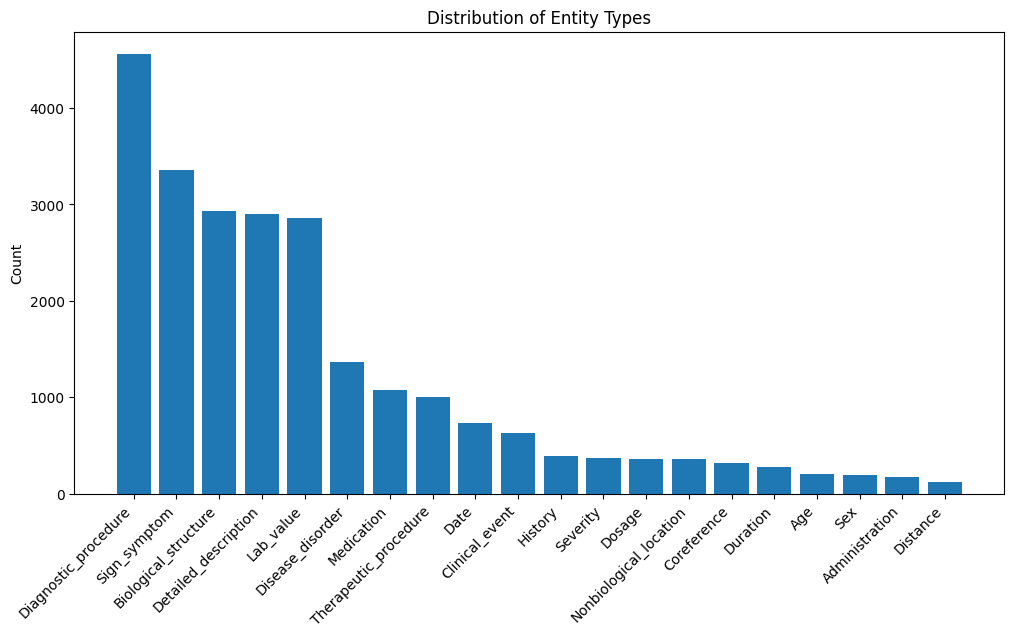

In [ ]:
entity_type_counts = {}
for doc_id in doc_ids:
    ann_file = doc_id + ".ann"
    with open(os.path.join(data_dir, ann_file)) as f:
        for line in f:
            if line.startswith("T"):
                entity_type = line.split()[1]
                entity_type_counts[entity_type] = entity_type_counts.get(entity_type, 0) + 1

entity_types = list(entity_type_counts.keys())
counts = list(entity_type_counts.values())

# sorts by count in descending order
entity_types_sorted = [x for _, x in sorted(zip(counts, entity_types), reverse=True)]
counts_sorted = sorted(counts, reverse=True)

# only keeps top 20 entities for visualization
entity_types_top = entity_types_sorted[:20]
counts_top = counts_sorted[:20]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(entity_types_top, counts_top)
ax.set_xticks(range(len(entity_types_top)))
ax.set_xticklabels(entity_types_top, rotation=45, ha="right")
ax.set_ylabel("Count")
ax.set_title("Distribution of Entity Types")
plt.show()


### Split when annotated token is a sequence of tokens

In [ ]:
def splitting_tokens(file_id, start, end, hyphen_split=True):
    """
    Splits a token into its constituent words and returns a list of tokens along with the corresponding
    ranges for each word in the original text.
    """
    text = data[file_id]['text']
    token = text[start:end]

    extra_sep = ['\u200a']
    if hyphen_split:
        extra_sep += ['-', '\u2010', '\u2011', '\u2012', '\u2013', '\u2014', '\u2015', '\u2212', '\uff0d']

    new_range = []
    tokens = []

    curr = start
    new_start = None

    for c in token + " ":
        if c.isspace() or c in extra_sep:
            if new_start:
                new_range.append([new_start, curr])
                tokens.append(text[new_start:curr])
                new_start = None
        elif not new_start:
            new_start = curr
        curr += 1

    return tokens, new_range


### Load ann data

In [ ]:
def load_ann_data(ann_dir, doc_ids, data, hyphen_split=True):
    """
    Loads annotations from a directory of .ann files and adds them to the corresponding 
    files in a data dictionary.
    """
    for doc_id in doc_ids:

        file_name = doc_id + ".ann"
        
        with open(os.path.join(ann_dir, file_name), "r") as f:

            annotations = []

            for line in f:
                if line.startswith("T"):
                    fields = line.strip().split("\t")
                    if len(fields[1].split(" ")) > 1:
                        label = fields[1].split(" ")[0]

                        # Extracting start end indices (Few annotations contain more than one disjoint ranges)
                        start_end_range = [
                            list(map(int, start_end.split()))
                            for start_end in ' '.join(fields[1].split(" ")[1:]).split(';')
                        ]

                        start_end_range_fixed = []
                        for start, end in start_end_range:
                            tokens, start_end_split_list = splitting_tokens(doc_id, start, end,
                                                                                  hyphen_split)
                            start_end_range_fixed.extend(start_end_split_list)

                        # Adding labels, start, end to annotations
                        for start, end in start_end_range_fixed:
                            annotations.append({
                                "label": label,
                                "start": start,
                                "end": end
                            })
            # sort annotations based on 'start' key before adding it to our dataset
            annotations = sorted(annotations, key=lambda x: (x['start'], x['label']))
            data[doc_id]["annotations"] = annotations
                
    return data

**Loading Data into _data_ dictionary**

In [25]:
data = load_ann_data(data_dir, doc_ids, data)

**Looking at the _data_ dictionary**

In [26]:
for doc_id in list(data.keys())[:3]:
    text = data[doc_id]['text']
    annotations = data[doc_id]['annotations']
    print(f"text:\n{text[:40]} .....")
    print(f"annotations:\n{annotations[:2]} .....")

text:
Our 24-year-old non-smoking male patient .....
annotations:
[{'label': 'Age', 'start': 4, 'end': 6}, {'label': 'Age', 'start': 7, 'end': 11}] .....
text:
A 68-year-old female nonsmoker, nondrink .....
annotations:
[{'label': 'Age', 'start': 2, 'end': 4}, {'label': 'Age', 'start': 5, 'end': 9}] .....
text:
A 25-year-old female patient had noticed .....
annotations:
[{'label': 'Age', 'start': 2, 'end': 4}, {'label': 'Age', 'start': 5, 'end': 9}] .....


In [27]:
entities = set()
for doc_id, doc in data.items():
    for ann in doc['annotations']:
        entities.add(ann['label'])
entities

{'Activity',
 'Administration',
 'Age',
 'Area',
 'Biological_attribute',
 'Biological_structure',
 'Clinical_event',
 'Color',
 'Coreference',
 'Date',
 'Detailed_description',
 'Diagnostic_procedure',
 'Disease_disorder',
 'Distance',
 'Dosage',
 'Duration',
 'Family_history',
 'Frequency',
 'Height',
 'History',
 'Lab_value',
 'Mass',
 'Medication',
 'Nonbiological_location',
 'Occupation',
 'Other_entity',
 'Other_event',
 'Outcome',
 'Personal_background',
 'Qualitative_concept',
 'Quantitative_concept',
 'Severity',
 'Sex',
 'Shape',
 'Sign_symptom',
 'Subject',
 'Texture',
 'Therapeutic_procedure',
 'Time',
 'Volume',
 'Weight'}

### Token frequency analysis

In [31]:
# Define the function to get token counts
def get_token_counts(data, remove_stop_words=True):
    token_counts = Counter()
    stop_words = set(stopwords.words('english'))
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        for annotation in annotations:
            label = annotation['label']
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens = annotated_text.split()
            if remove_stop_words:
                annotated_tokens = [token for token in annotated_tokens if token.lower() not in stop_words]
            token_counts.update(annotated_tokens)
    return token_counts

### Annotated token frequency (without removing stop_words)

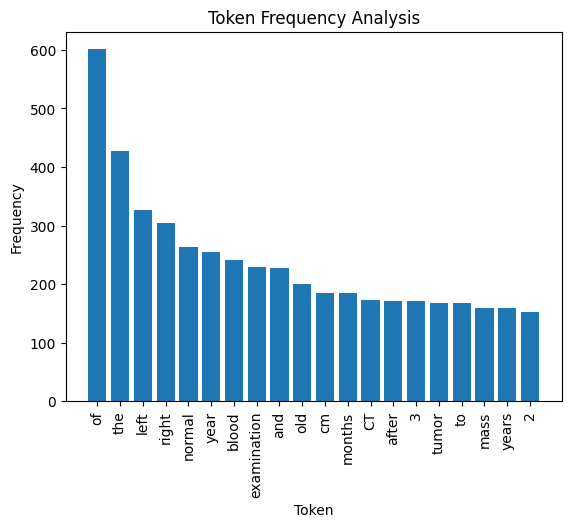

In [32]:
token_counts = get_token_counts(data, remove_stop_words=False)

# Sort the tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most common tokens and their counts
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Create the bar plot
plt.bar(top_tokens, top_counts)
plt.xticks(rotation=90)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Token Frequency Analysis')
plt.show()


### Annotated token frequency (After removing stop_words)

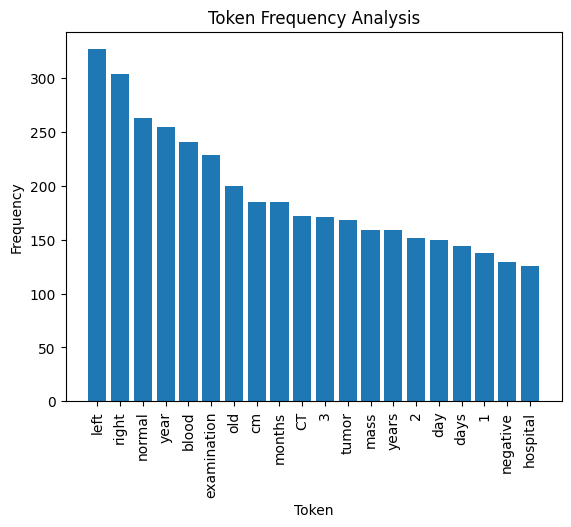

In [33]:

token_counts = get_token_counts(data)

# Sort the tokens by frequency
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Get the top 20 most common tokens and their counts
top_tokens = [t[0] for t in sorted_tokens[:20]]
top_counts = [t[1] for t in sorted_tokens[:20]]

# Create the bar plot
plt.bar(top_tokens, top_counts)
plt.xticks(rotation=90)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Token Frequency Analysis')
plt.show()


### Collocation analysis

In [34]:
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

# Define the function to get collocations
def get_collocations(data):
    # Tokenize the text and filter out stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokenized_text = [word.lower() for file_id, file_data in data.items() for word in file_data['text'].split() if word.lower() not in stop_words]

    # Create a bigram collocation finder
    bigram_measures = BigramAssocMeasures()
    bigram_finder = BigramCollocationFinder.from_words(tokenized_text)

    # Filter out low frequency bigrams and get the top 10 collocations
    bigram_finder.apply_freq_filter(5)
    top_collocations = bigram_finder.nbest(bigram_measures.pmi, 10)

    return top_collocations
get_collocations(data)

[('ground', 'glass'),
 ('glasgow', 'coma'),
 ('lesser', 'curvature'),
 ('egfr', 'tki'),
 ('vena', 'cava'),
 ('bronchoalveolar', 'lavage'),
 ('glomerular', 'filtration'),
 ('muscularis', 'propria'),
 ('6-minute', 'walk'),
 ('alkaline', 'phosphatase')]

In [35]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

def get_collocations(data):
    collocations = []
    for file_id, file_data in data.items():
        text = file_data['text']
        annotations = file_data['annotations']
        annotated_tokens = []
        for annotation in annotations:
            start = annotation['start']
            end = annotation['end']
            annotated_text = text[start:end]
            annotated_tokens += annotated_text.split()

        finder = BigramCollocationFinder.from_words(annotated_tokens)
        bigram_measures = BigramAssocMeasures()
        scored = finder.score_ngrams(bigram_measures.raw_freq)
        collocations += scored

    return collocations
get_collocations(data)

[(('lower', 'right'), 0.01652892561983471),
 (('malignant', 'cells'), 0.01652892561983471),
 (('12', '×'), 0.008264462809917356),
 (('15', 'mm'), 0.008264462809917356),
 (('2%', 'size'), 0.008264462809917356),
 (('2008', '4'), 0.008264462809917356),
 (('24', 'year'), 0.008264462809917356),
 (('4', 'cm'), 0.008264462809917356),
 (('4', 'days'), 0.008264462809917356),
 (('6', 'months'), 0.008264462809917356),
 (('Abrikossoff', 'tumor'), 0.008264462809917356),
 (('CT', 'scan'), 0.008264462809917356),
 (('Cuban', 'cold'), 0.008264462809917356),
 (('Four', 'days'), 0.008264462809917356),
 (('May', '2008'), 0.008264462809917356),
 (('S100', 'positive'), 0.008264462809917356),
 (('admission.', 'histological'), 0.008264462809917356),
 (('after', 'discharge'), 0.008264462809917356),
 (('after', 'recovery'), 0.008264462809917356),
 (('after', 'the'), 0.008264462809917356),
 (('biopsy', 'mass'), 0.008264462809917356),
 (('bleeding', 'biopsy'), 0.008264462809917356),
 (('breathing', 'holidays'), 0

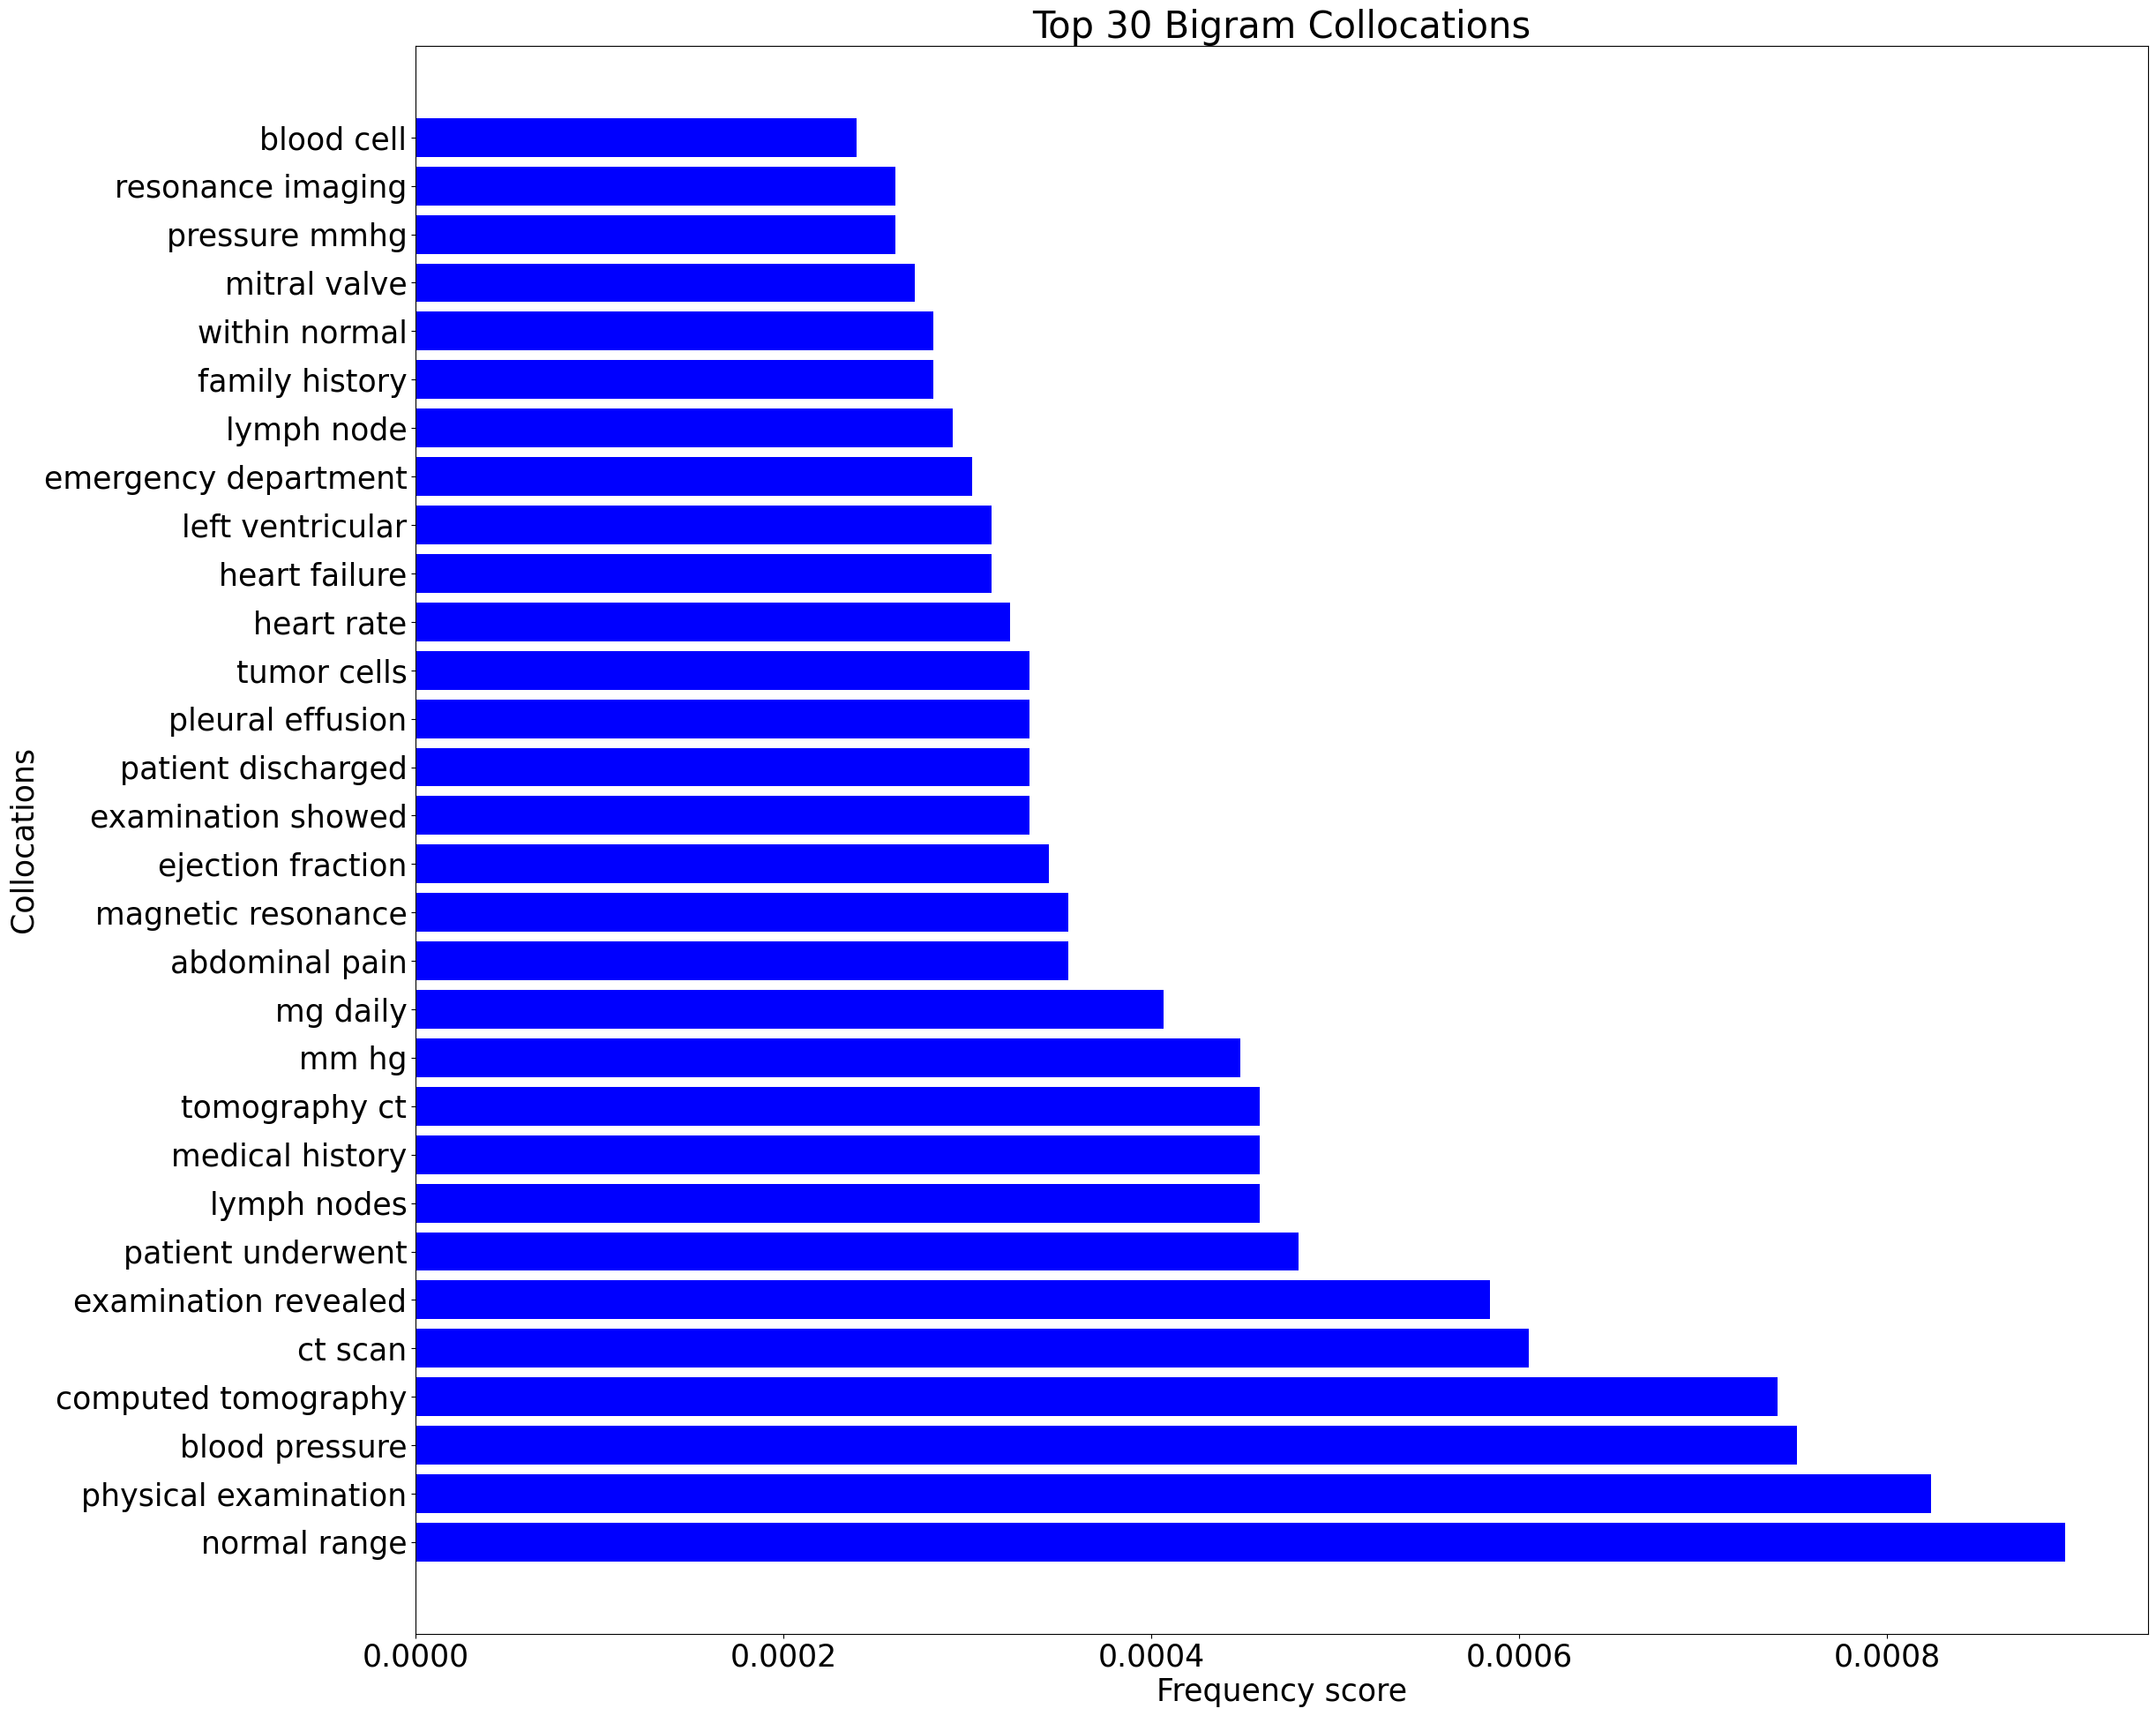

In [36]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

nlp = spacy.load('en_core_web_sm')

# Load stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

all_tokens = []

for doc_id, doc in data.items():
    contents = doc['text']
    # tokenize the text
    tokens = nltk.word_tokenize(contents.lower())
    # remove stop words and punctuation
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    all_tokens.extend(tokens)

# create bigrams
bigrams = list(nltk.bigrams(all_tokens))
# create a bigram collocation finder
finder = BigramCollocationFinder.from_documents(bigrams)
# apply a scoring metric to rank the collocations
scored = finder.score_ngrams(BigramAssocMeasures().raw_freq)
# get the top 30 collocations
collocations = [' '.join(collocation) for collocation, score in scored[:30]]

# create a pandas dataframe with the collocations and their frequency
collocations_freq = [score for collocation, score in scored[:30]]
collocations = [' '.join(collocation) for collocation, score in scored[:30]]
df = pd.DataFrame({'collocation': collocations, 'frequency': collocations_freq})

# plot the collocations as a bar chart
plt.figure(figsize=(25, 20))
plt.rcParams.update({'font.size': 25})
plt.barh(df['collocation'], df['frequency'], color='blue')
plt.title('Top 30 Bigram Collocations')
plt.ylabel('Collocations')
plt.xlabel('Frequency score')
plt.tight_layout()  # optional, to improve spacing

plt.show()



### Distribution of Entity types

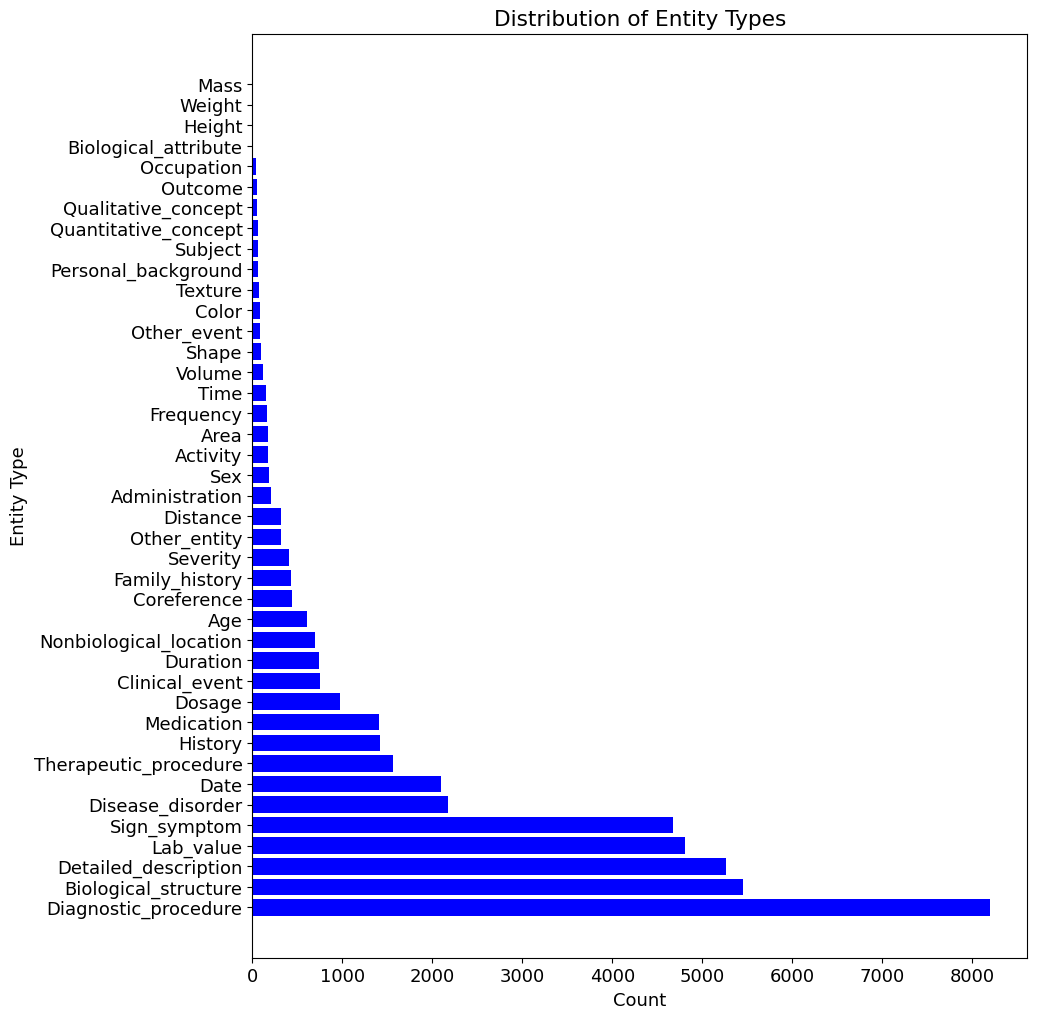

In [37]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# Create an empty dictionary to store entity types and their counts
entity_counts = {}

# Loop through each document in your data dictionary
for doc_id, doc in data.items():
    contents = doc['text']
    annotations = doc['annotations']

    # Create a Doc object from the text
    doc = nlp(contents)
    prev_end = -1
    # Add your custom annotations to the Doc object
    for ann in annotations:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
        
    # Loop through each entity in the parsed document
    for ent in doc.ents:
        # If the entity type is not in the entity_counts dictionary, add it with a count of 1
        if ent.label_ not in entity_counts:
            entity_counts[ent.label_] = 1
        # If the entity type is already in the entity_counts dictionary, increment its count by 1
        else:
            entity_counts[ent.label_] += 1        
            
# Convert the entity_counts dictionary to a pandas DataFrame for plotting
df = pd.DataFrame({'Entity Type': list(entity_counts.keys()), 'Count': list(entity_counts.values())})

# Sort the DataFrame by count in descending order
df = df.sort_values(by=['Count'], ascending=False)

# Plot the entity type counts as a bar chart
plt.rcParams.update({'font.size': 13})

plt.figure(figsize=(10, 12))
plt.barh(df['Entity Type'], df['Count'], color='blue')

plt.title('Distribution of Entity Types')
plt.ylabel('Entity Type')
plt.xlabel('Count')
plt.show()

### Analyzing the entity lengths, frequencies, and contexts.

In [38]:
# load the data
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# get the entity lengths
entity_lengths = []
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_lengths.append(ann['end'] - ann['start'])

# get the entity frequencies
entity_frequencies = Counter()
for doc_id in data:
    for ann in data[doc_id]['annotations']:
        entity_frequencies[ann['label']] += 1

# get the entity contexts
entity_contexts = {}
for doc_id in data:
    doc = nlp(data[doc_id]['text'])
    
    for ann in data[doc_id]['annotations']:
        label = ann["label"]
        start = ann["start"]
        end = ann["end"]
        if start > prev_end:
            span = doc.char_span(start, end, label=label)
            if span is not None:
                doc.ents += tuple([span])
        prev_end = end
    
    for ent in doc.ents:
        label = ent.label_
        start = ent.start_char
        end = ent.end_char
        context = doc[max(0, start-5):end+5].text
        if label not in entity_contexts:
            entity_contexts[label] = []
        entity_contexts[label].append(context)

# print the results
print('Entity lengths:')
print('  Min:', min(entity_lengths))
print('  Max:', max(entity_lengths))
print('  Mean:', sum(entity_lengths)/len(entity_lengths))
print('Entity frequencies:')
for label, freq in entity_frequencies.items():
    print('  {}: {}'.format(label, freq))
print('Entity contexts:')
for label, contexts in entity_contexts.items():
    print('  {}:'.format(label))
    for context in contexts[:3]:
        if context:
            print('    - {}'.format(context))


Entity lengths:
  Min: 1
  Max: 54
  Mean: 6.400996345283676
Entity frequencies:
  Age: 613
  History: 1846
  Sex: 191
  Clinical_event: 757
  Detailed_description: 5319
  Sign_symptom: 4814
  Date: 2112
  Duration: 756
  Biological_structure: 5488
  Personal_background: 73
  Severity: 415
  Texture: 77
  Coreference: 437
  Diagnostic_procedure: 8364
  Area: 174
  Disease_disorder: 2209
  Lab_value: 5005
  Therapeutic_procedure: 1601
  Distance: 325
  Medication: 1444
  Dosage: 991
  Shape: 94
  Administration: 205
  Nonbiological_location: 695
  Qualitative_concept: 56
  Frequency: 170
  Activity: 179
  Volume: 122
  Quantitative_concept: 65
  Outcome: 54
  Subject: 78
  Color: 82
  Other_event: 94
  Time: 169
  Family_history: 493
  Biological_attribute: 13
  Height: 8
  Mass: 4
  Occupation: 41
  Weight: 8
  Other_entity: 327
Entity contexts:
  Age:
    - -year-old non-smoking male patient presented with repeated hemoptysis in
    - -smoking male patient presented with repeated hemo

### Check for overlapping entities:

In [39]:
multi_label_words_count = 0
multi_label_files_count = 0
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] >= annotations[i+1]['start']:
            overlapping = True
            multi_label_words_count += 1
            # print(f"Overlap found between {annotations[i]} and {annotations[i+1]}")

    if overlapping:
        multi_label_files_count += 1
        
print(f"Total number of words with multi labels found is {multi_label_words_count}")
print(f"Total number of files with multi labelled words is {multi_label_files_count}")

Total number of words with multi labels found is 826
Total number of files with multi labelled words is 105


In [40]:
total_count = 0
overlapping_count_dict = {}
for doc_id in data:

    overlapping_count = 0
    
    text = data[doc_id]['text']
    
    annotations = data[doc_id]['annotations']
    
    for i in range(len(annotations)-1):
        label = annotations[i]['label']
        start = annotations[i]['start']
        end = annotations[i]['end']
        
        if annotations[i]['end'] > annotations[i+1]['start']:
            total_count += 1
            overlapping_count += 1
    overlapping_count_dict[doc_id] = overlapping_count

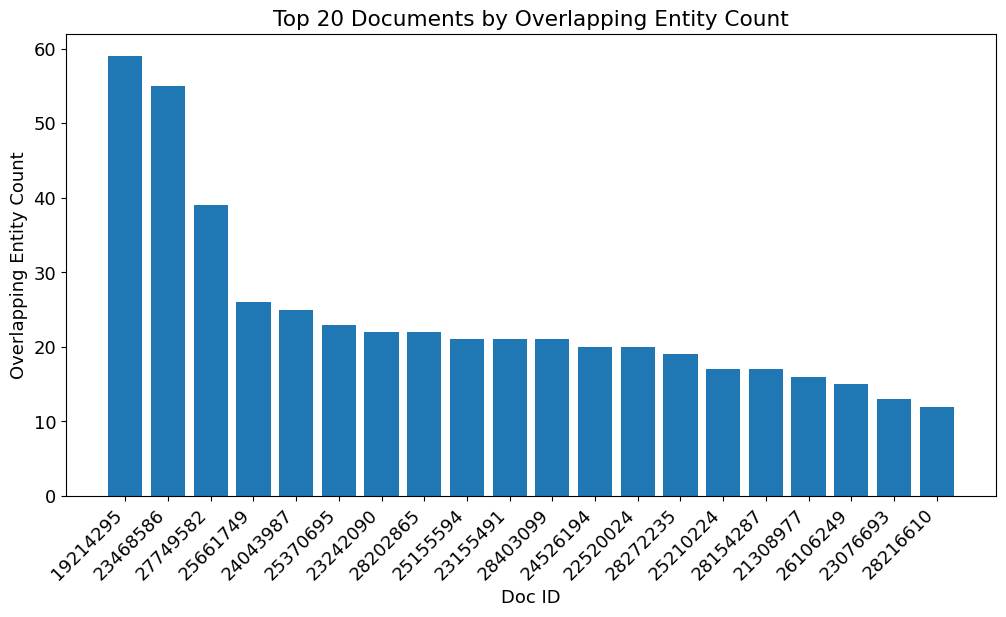

In [41]:
import matplotlib.pyplot as plt

sorted_dict = dict(sorted(overlapping_count_dict.items(), key=lambda item: item[1], reverse=True)[:20])
doc_ids = list(sorted_dict.keys())
overlapping_counts = list(sorted_dict.values())

fig, ax = plt.subplots(figsize=(12,6))


ax.set_xlabel('Doc ID')
ax.set_ylabel('Overlapping Entity Count')
ax.set_title('Top 20 Documents by Overlapping Entity Count')
ax.set_xticks(range(len(doc_ids)))  # set the tick locations
ax.set_xticklabels(doc_ids, rotation=45, ha='right')  # set the tick labels
ax.bar(doc_ids, overlapping_counts)
plt.show()



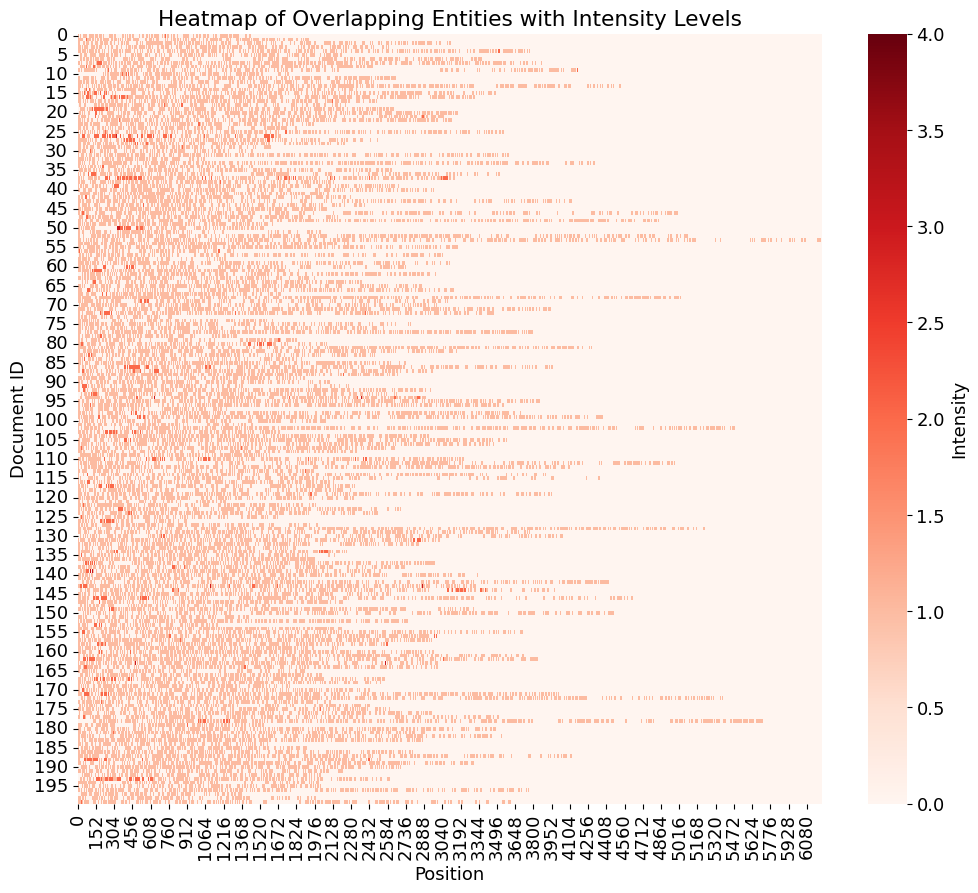

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create the entity_ranges dictionary
entity_ranges = {}
max_end_of_text = 0

for doc_id in data:
    text = data[doc_id]['text']
    if len(text) > max_end_of_text:
        max_end_of_text = len(text)
        
    annotations = data[doc_id]['annotations']
    doc_entity_ranges = []
    for ann in annotations:
        start = ann['start']
        end = ann['end']
        doc_entity_ranges.append((start, end))
    entity_ranges[doc_id] = doc_entity_ranges

# create the heatmap with overlapping intensity levels
heatmap = np.zeros((len(entity_ranges), max_end_of_text))
row = 0
for doc_id, doc_entity_ranges in entity_ranges.items():
    for start, end in doc_entity_ranges:
        for i in range(start, end):
            heatmap[row][i] += 1
    row += 1
# plot the heatmap with Seaborn
plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap, cmap='Reds', cbar_kws={'label': 'Intensity'})
ax.set_xlabel('Position')
ax.set_ylabel('Document ID')
ax.set_title('Heatmap of Overlapping Entities with Intensity Levels')

plt.show()


### Checking if subwords overlaps

Checking if there are any annotated start_end_range partially overlapping

In [ ]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if word_1 != word_2:
                print(f"part of words overlaps: {word_1} {word_2}")

part of words overlaps: old old,
part of words overlaps: symmetry, symmetry
part of words overlaps: months months’
part of words overlaps: years years.
part of words overlaps: walking walking,
part of words overlaps: (LV) LV
part of words overlaps: hepatitis hepatitis,
part of words overlaps: long ong
part of words overlaps: insufficiency insufficiency,
part of words overlaps: IIA, IIA
part of words overlaps: T1bN1, T1bN1
part of words overlaps: bacteria bacteria,
part of words overlaps: diarrhoea, diarrhoea
part of words overlaps: intake intake,
part of words overlaps: drugs drugs,
part of words overlaps: tobacco tobacco,
part of words overlaps: pork, pork
part of words overlaps: consanguineous consanguineous,
part of words overlaps: output, output
part of words overlaps: dialysis, dialysis
part of words overlaps: intolerance, intolerance
part of words overlaps: palpitation, palpitation
part of words overlaps: GD GD,
part of words overlaps: smoking smoking,
part of words overlaps: sib

We could see that there are a lot of overlapped annotated tokens differs by a trailing punctuations.

It means for some tokens, duplicate annotations exists 
* one that doesn't include trailing puncutation 
* one that includes trailing punctuations

In [44]:
# Count number of files starting and ending with punctuation
start_punct_count = 0
end_punct_count = 0
neither_punct_count = 0

# Loop through each file in the data dictionary
for file_id, file_data in data.items():

    for annotation in file_data['annotations']:
        
        # Get the annotated text
        annotated_text = file_data['text'][annotation['start']:annotation['end']]
        # Check if the first or last character of the annotated text is a punctuation character
        if annotated_text[0] in string.punctuation:
            start_punct_count += 1
        elif annotated_text[-1] in string.punctuation:
            end_punct_count += 1
        else:
            neither_punct_count += 1
            
# Print counts in table format
print('{:<25}{}'.format('Category', 'Count'))
print('-'*35)
print('{:<25}{}'.format('Starts with punctuation', start_punct_count))
print('{:<25}{}'.format('Ends with punctuation', end_punct_count))
print('{:<25}{}'.format('Neither', neither_punct_count))


Category                 Count
-----------------------------------
Starts with punctuation  158
Ends with punctuation    512
Neither                  45298


#### Removing Trailing Punctuation

In [45]:
def remove_trailing_punctuation(token):
    """
    Removes trailing punctuation from a token.

    Args:
        token (str): A string representing the token to be cleaned.

    Returns:
        str: The cleaned token with trailing punctuation removed.
    """
    while token and re.search(r'[^\w\s\']', token[-1]):
        token = token[:-1]
        
    return token

In [46]:
for file_id in data:
    annotations = data[file_id]['annotations']
    overlapping = False

    for i in range(len(annotations)-1):
        if annotations[i]['end'] > annotations[i+1]['start']:
            overlapping = True
            word_1 = data[file_id]['text'][annotations[i]['start']:annotations[i]['end']]
            word_2 = data[file_id]['text'][annotations[i+1]['start']:annotations[i+1]['end']]

            if remove_trailing_punctuation(word_1) != remove_trailing_punctuation(word_2):
                print(f"doc_id: {file_id} words: {word_1} {word_2}", end=" | ")
                print(f"labels: {file_id} {annotations[i]['label']} {annotations[i]['start']} {annotations[i]['end']}, {annotations[i+1]['label']} {annotations[i+1]['start']} {annotations[i+1]['end']}")

doc_id: 23468586 words: (LV) LV | labels: 23468586 History 314 318, Disease_disorder 315 317
doc_id: 19214295 words: long ong | labels: 19214295 Detailed_description 424 428, History 425 428
doc_id: 27749582 words: (HBV) HBV | labels: 27749582 History 253 258, Detailed_description 254 257


Fixing "doc_id: 19214295 words: long ong | labels: 19214295 Detailed_description 424 428, History 425 428"

In [47]:
for annotation in data['19214295']['annotations']:
    if annotation['start'] == 425:
        annotation['start'] = 424

### Saving data dictionary to a json file

In [48]:
def create_json(preprocessed_data_dir, data):

    if os.path.exists(preprocessed_data_dir):
        # Delete the contents of the directory
        shutil.rmtree(preprocessed_data_dir)
    # Recreate the directory
    os.makedirs(preprocessed_data_dir)
    
    # Write the dictionary to a JSON file
    with open(os.path.join(preprocessed_data_dir, "annotated_data.json"), "w") as f:
        json.dump(data, f)

In [49]:
preprocessed_data_dir = "../data/raw/annotated_json_data"
create_json(preprocessed_data_dir, data)

## Summary
In this notebook, we've:

1. Loaded and explored the MACCROBAT2018 clinical dataset containing 200 annotated documents
2. Performed detailed analysis of document structure (length distribution, sentence counts)
3. Generated visualizations of word frequency distributions and entity type distributions
4. Processed annotations into a structured format with proper entity boundaries
5. Identified and resolved overlapping entities and punctuation-related annotation issues
7. Analyzed entity characteristics including length, frequency, and contextual patterns
8. Saved the processed data as structured JSON for downstream NER model training

The dataset is now thoroughly analyzed and preprocessed, ready for named entity recognition model development.